# Prologue
Made with help of https://www.datanovia.com/en/blog/how-to-perform-multiple-t-test-in-r-for-different-variables/ with inline running of code like in Rstudio using ```CTRL+SHIFT+ENTER``` enabled by https://stackoverflow.com/questions/56460834/how-to-run-a-single-line-or-selected-code-in-a-jupyter-notebook-or-jupyterlab-ce

# Demo of basic stats
In this tutorial I will be teaching you how to apply the **Two sample t-test** to a real life dataset I ran into at work. The purpose of this statistical technique is to compare means between two groups. The assumptions are that your data is normally distributed, the values are continous not cateogrial, and the variance is roughly equal.

The golden question we are trying to answer during this tutorial will be
> Are the cells proportions in Control mice or Treatment mice significantly different?

### Here are just some necessary packages

In [1]:
library(rstatix)
library(ggpubr)
library(pals)
library(tidyr)
library(plyr)
library(dplyr)
library(openxlsx)
library(cowplot)
library(reshape2)
library(patchwork)
library(ggplot2)
library(Matrix)


Attaching package: ‘rstatix’

The following object is masked from ‘package:stats’:

    filter

Loading required package: ggplot2

Attaching package: ‘plyr’

The following object is masked from ‘package:ggpubr’:

    mutate

The following objects are masked from ‘package:rstatix’:

    desc, mutate


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggpubr’:

    get_legend


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



ERROR: Error in library(patchwork): there is no package called ‘patchwork’


### Step 1 read in the data

In [29]:
# Here we set the path for saving figures we make
path.peng.cibersort <- paste0("./figures")

# Now we read in the results of running Cibersortx on 
# some bulk RNASeq data. The ID column is locked inside
# of csx$Mixture, so we need to split it out.

# The shape of the data is experiment x cell.type.info
csx <- read.table(file='./data/CIBERSORTx_Job16_Results.csv', sep=',', header=T)
csx$ID <- sapply(strsplit(as.character(csx$Mixture), "_"), FUN=function(x) {paste0("V",x[2])})

print("The data looks like this. The important columns are CM, EC, PC.SMC, FB, Epi, and BC. They stand for our celltypes like CM=cardiomyocytes (heart muscle cells)")
csx[1:5,]

[1] "The data looks like this. The important columns are CM, EC, PC.SMC, FB, Epi, and BC. They stand for our celltypes like CM=cardiomyocytes (heart muscle cells)"


Mixture,CM,EC,PC.SMC,FB,Epi,BC,P.value,Correlation,RMSE,Absolute.score..sig.score.,ID
Trimmed_2504_S4,452.7622,121.1442,22.84093,48.68887,69.33015,38.58329,0,0.8691461,0.4955567,753.3496,V2504
Trimmed_2507_S5,300.9424,188.0735,25.28128,58.73485,66.03680,38.39605,0,0.8569723,0.5185446,677.4649,V2507
Trimmed_2508_S6,729.0330,201.0742,38.22115,120.52627,101.53954,53.55776,0,0.8518270,0.5246397,1243.9519,V2508
Trimmed_2509_S7,347.4602,217.7420,27.27930,65.13272,68.63991,37.77995,0,0.8579870,0.5164089,764.0341,V2509
Trimmed_2510_S8,314.8530,204.0644,44.52279,58.24048,62.22223,33.48388,0,0.8447885,0.5371849,717.3868,V2510


In [30]:
# Here is some meta data about the samples. 
# The most useful thing is information about
# whether samples are control or treatment.
# Shape of data: experiment x group.
bulk.meta <- read.xlsx('./data/D21-09_RNA-Seq.xlsx', colNames = T)
bulk.meta <- plyr::rename(bulk.meta, replace=c("X1"="exp.assay"))
bulk.meta$`Heart.Bulk.RNA-seq` <- NULL

print("Here is some extra meta data. The only important value we care to use here is exp.assay. 
That tells us whether this particular mouse was in the control group, or the other treatment groups. 
Otherwise it is basically in the same shape as my other data")
head(bulk.meta)

[1] "Here is some extra meta data. The only important value we care to use here is exp.assay. \nThat tells us whether this particular mouse was in the control group, or the other treatment groups. \nOtherwise it is basically in the same shape as my other data"


exp.assay,ID,Nppb,Col3a1
Control,V2501,1.2999340,0.9000799
Control,V2502,0.7323207,0.5339927
Control,V2503,1.3504726,1.7643171
Control,V2504,0.7107017,1.1455777
Control,V2507,1.3474831,0.8229885
Control,V2508,1.0170109,0.7681348


In [31]:
# We have two columns called ID that match in my two
# dataframes. Lets use that to merge the two into one.
# This is the block of code that will help us do thatbulk.meta[match(csx[,'ID'], bulk.meta[,"ID"]),]

# Final cibersort object with meta data attached.
csx <- cbind(csx, bulk.meta[match(csx[,'ID'], bulk.meta[,"ID"]),c('exp.assay', "Nppb", "Col3a1")])
head(csx)

,Mixture,CM,EC,PC.SMC,FB,Epi,BC,P.value,Correlation,RMSE,Absolute.score..sig.score.,ID,exp.assay,Nppb,Col3a1
4,Trimmed_2504_S4,452.7622,121.1442,22.84093,48.68887,69.33015,38.58329,0,0.8691461,0.4955567,753.3496,V2504,Control,0.7107017,1.1455777
5,Trimmed_2507_S5,300.9424,188.0735,25.28128,58.73485,66.03680,38.39605,0,0.8569723,0.5185446,677.4649,V2507,Control,1.3474831,0.8229885
6,Trimmed_2508_S6,729.0330,201.0742,38.22115,120.52627,101.53954,53.55776,0,0.8518270,0.5246397,1243.9519,V2508,Control,1.0170109,0.7681348
7,Trimmed_2509_S7,347.4602,217.7420,27.27930,65.13272,68.63991,37.77995,0,0.8579870,0.5164089,764.0341,V2509,Control,0.9712424,0.8443785
8,Trimmed_2510_S8,314.8530,204.0644,44.52279,58.24048,62.22223,33.48388,0,0.8447885,0.5371849,717.3868,V2510,Control,0.6792275,1.0274589
9,Trimmed_2521_S9,384.5597,175.9966,28.03115,106.78729,71.00160,45.49224,0,0.8677850,0.5015445,811.8686,V2521,HFpEF-Veh,1.6620137,1.8744840


We have read in the data and polished our data. We now have 1 dataframe
with the shape of </br>```experiment x categories```

### Plotting the data
My data currently has 3 categorical pieces of information. First it has an experimental name denoting what mouse this is coming from. Additionally each mouse was assigned to a condition/group **HFpEF-veh, Control-veh, HFpEF-TYA018, and HFpEF-SGLT2i**. Lastly for each experiment (mouse), we have broken up the sample into celltypes.

Thus the values we will be comparing are the proportions of celltypes between conditions, and each experimental mouse is a replicate---a sample from a population.

In [35]:
# Currently the data is in "wide" format. We need to gather it into
# "long" format, which R makes easy for us. https://www.statology.org/long-vs-wide-data/#:~:text=A%20dataset%20can%20be%20written,repeat%20in%20the%20first%20column.&text=Notice%20that%20in%20the%20wide,the%20first%20column%20is%20unique.
# This piece of code smooshes the columns CM, EC, PC.SMC, FB, Epi, and BC into one
# column named cell.type, and puts the values into a column called abund.
data.ciber <- gather(csx, cell.type, abund, CM:BC, factor_key=TRUE)
print("ID column is the 'name' of the mouse. Exp.assay column is the experimental
condition the mouse is subject to. The cell.type column contains what celltype 
we are refering to coming from this particular mouse, and abundance is the amount
of that celltype measured.")
print("")
print(head(data.ciber[,c("ID", "exp.assay", "cell.type", "abund")]))

[1] "ID column is the 'name' of the mouse. Exp.assay column is the experimental\ncondition the mouse is subject to. The cell.type column contains what celltype \nwe are refering to coming from this particular mouse, and abundance is the amount\nof that celltype measured."
[1] ""
     ID exp.assay cell.type    abund
1 V2504   Control        CM 452.7622
2 V2507   Control        CM 300.9424
3 V2508   Control        CM 729.0330
4 V2509   Control        CM 347.4602
5 V2510   Control        CM 314.8530
6 V2521 HFpEF-Veh        CM 384.5597


In [38]:
# We define a color palette, in this case
# I like glasbey.
palette.ciber <- unique(data.ciber$cell.type)
names(palette.ciber) <- glasbey(length(unique(data.ciber$cell.type)))

print("Colors are in hexadecimal")
print(palette.ciber)

[1] "Colors are in hexadecimal"
#0000FF #FF0000 #00FF00 #000033 #FF00B6 #005300 
     CM      EC  PC.SMC      FB     Epi      BC 
Levels: CM EC PC.SMC FB Epi BC


In [42]:
# We need one last bit of data formatting. The absolute number 
# Cibersortx by default gives us isn't super useful. A percentage
# would be much more useful. Here we calculate it, and add it to 
# our dataframe.
data.ciber <- data.ciber %>% dplyr::group_by(Mixture) %>% dplyr::mutate(percent = prop.table(abund) * 100) %>% ungroup() 

print("As we can see, a new percent column is added.")
head(data.ciber[,c("ID", "exp.assay", "cell.type", "abund", "percent")])

[1] "As we can see, a new percent column is added."


ID,exp.assay,cell.type,abund,percent
V2504,Control,CM,452.7622,60.09988
V2507,Control,CM,300.9424,44.42185
V2508,Control,CM,729.0330,58.60620
V2509,Control,CM,347.4602,45.47705
V2510,Control,CM,314.8530,43.88887
V2521,HFpEF-Veh,CM,384.5597,47.36724


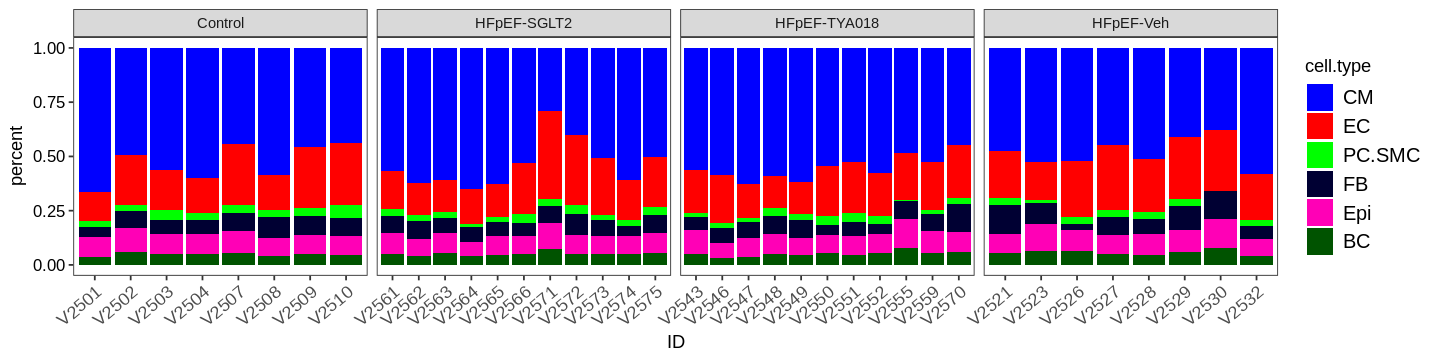

In [56]:
# Finally lets plot the data.
# X-axis = experiment
# y-axis = cell.type
# values = percents
# stat="identity" lets this be a stacked proportion barchart
# facet_grid lets us group an additional time by condtion/group
options(repr.plot.width=12, repr.plot.height=3)
plot.cibersort <- ggplot(data.ciber, aes(fill=cell.type, x=ID, y=percent)) + 
  geom_bar(position="fill",stat='identity') + theme_bw() +
  scale_fill_manual(values = names(palette.ciber)) + 
  #geom_text(aes(label = round(percent, 3)),
   #         colour='#FFFFFF', size = 4, angle = 90,
    #        position = position_fill(vjust = 0.5)) +
  facet_grid(~exp.assay, scales="free_x") +
  theme(axis.text.x = element_text(angle = 40, vjust = 1, hjust=1, lineheight = 0.75, size = 11),
        axis.text.y = element_text(family = "Arial", size = 10, face = "plain", color = "black"),
        plot.title = element_text(hjust = 0.5),
        legend.text = element_text(family = "Arial", size = 12, face = "plain", color = "black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank());plot.cibersort

ggsave("Peng_bulk_deconv_meta.png",plot = plot.cibersort,
       path = path.peng.cibersort, width = 13, height = 9, 
       units = 'in', )

As we can see, the cell population "CM" seems to be the highest proportion, but now we can start answering interesting questions
* Do the proportions of **CMs** significantly differ between HFpEF and Control groups?
and more generally
* Do the proportions of **celltypes** significantly differ between HFpEF and Control groups?

To help us solve this, we will need to perform a **Two sample t-Test** or a **Two sample wilcoxon test**.
Lets start by doing it one time by hand

# Performing a Two sample t-Test by hand on CMs

In [45]:
# Formula for a t.test https://www.youtube.com/watch?v=ZQv7C6g2uXQ
# (mu1 - mu2) / sqrt(S1/n1 + S2/n2)
# Question: Is HFpEF CM proportion different from Control?

# Lets read in just the data we need, without the junk columns
data.stats <- data.ciber[,c("ID", "cell.type","abund", "percent","exp.assay")]
head(data.stats)

ID,cell.type,abund,percent,exp.assay
V2504,CM,452.7622,60.09988,Control
V2507,CM,300.9424,44.42185,Control
V2508,CM,729.0330,58.60620,Control
V2509,CM,347.4602,45.47705,Control
V2510,CM,314.8530,43.88887,Control
V2521,CM,384.5597,47.36724,HFpEF-Veh


In [47]:
# We have our data, so lets calculate the mean
# and standard deviation for all celltypes, but
# look only at Control CMs and HFpEF CMs
data.stats %>%
  group_by(cell.type, exp.assay) %>% 
  dplyr::summarise(mean = mean(percent), SD = sd(percent)) %>% head(4)

`summarise()` has grouped output by 'cell.type'. You can override using the `.groups` argument.


cell.type,exp.assay,mean,SD
CM,Control,53.02583,8.417756
CM,HFpEF-SGLT2,53.80059,11.033652
CM,HFpEF-TYA018,55.40377,5.554454
CM,HFpEF-Veh,48.10395,6.630888


In [48]:
# Manually calculating the t.statistic (which is
# like the z.score or z.statistic), it is a meaure
# of how many standard deviations away our observed
# values are from each other. I don't fully remember why
# the denominators add the way they do, but it has to do
# with the fact that variances add even when means are
# subtracted.
t.score <- (53 - 48.1) / sqrt(8.42^2/8 + 6.63^2/8); t.score
# [1] 1.293211

# Need around 2.4 to be considered significant
# We essentially have a Z-score of 1.29, so lets calculate
# the probability we got this by chance. 7 is the degrees 
# of freedom, which is how many samples we have -1. Now, we
# have two tests with equal numbers of samples, but I assume
# we would chose the lower sample for our degree of freedom 
# here.

# We also multiply by 2 because this is a two tailed test.
# We had around a 25% chance of getting the result we did
# just by random chance (this isn't even corrected). Pretty
# insignificant result.
print(paste0("Probability we observed difference between HFpEF and Control by chance: ", 2*pt(t.score, 7, lower.tail=F)))
# [1] 0.2347678

[1] 1.293211

[1] "Probability we observed difference between HFpEF and Control by chance: 0.236977743310933"


<br><br>Well we calculated the difference between Control and HFpEF CMs by hand, but we have 5 more celltypes to go through, and that would be a pain to calculate by hand. I would also like to create a visual to go along with these results. So lets do it!

# Calculating significance of differences between all celltypes

In [51]:
# Lets once again subset our original data to only the columns we care about
data.stats <- data.ciber[,c("ID", "cell.type","abund", "percent","exp.assay")]

# We can calculate the t.statistic programatically here. We cluster by celltype, then 
# hand R the formula percent depends on exp.assay column, and ask it to compare the 
# HFpEF and Control categories.

# The important columns here are cell.type and p.adj, and it looks like none of my 
# comparisons are significant!!!
print("This is the generated comparisons in my data. The important columns are 'statistic'
which is the t-statistic. P column is the p-value, and we can notice that it is similar to
the value we calculated for CMs, but not exactly the same! I don't actually know why!")
stat.test <- data.stats %>%
  group_by(cell.type) %>%
  t_test(formula =percent ~ exp.assay, comparisons = list(c('HFpEF-Veh', "Control"))); stat.test

[1] "This is the generated comparisons in my data. The important columns are 'statistic'\nwhich is the t-statistic. P column is the p-value, and we can notice that it is similar to\nthe value we calculated for CMs, but not exactly the same! I don't actually know why!"


cell.type,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
CM,percent,Control,HFpEF-Veh,8,8,1.2991321,13.272168,0.216,0.216,ns
EC,percent,Control,HFpEF-Veh,8,8,-1.1993756,12.298347,0.253,0.253,ns
PC.SMC,percent,Control,HFpEF-Veh,8,8,1.8423323,13.743741,0.087,0.087,ns
FB,percent,Control,HFpEF-Veh,8,8,-0.8618958,9.605017,0.410,0.410,ns
Epi,percent,Control,HFpEF-Veh,8,8,-1.3494162,9.439647,0.209,0.209,ns
BC,percent,Control,HFpEF-Veh,8,8,-1.4188476,12.166772,0.181,0.181,ns


In [ ]:
# This just adds a couple of columns to be used
# with the stat_pvalue_manual ggplot2 function
# below
stat.test <- stat.test %>% add_xy_position(x = "exp.assay")
stat.test$xmax <- rep(2, dim(stat.test)[1])

# Plotting it from https://www.datanovia.com/en/blog/how-to-perform-multiple-t-test-in-r-for-different-variables/
options(repr.plot.width=12, repr.plot.height=6)
plot.bulk.diff <- ggboxplot(
  data.stats, x = "exp.assay", y = "percent",
  fill = "exp.assay", palette = "npg", legend = "none",
  ggtheme = theme_pubr(border = TRUE)
) +
  stat_pvalue_manual(stat.test, label = "p.adj.signif") +
  facet_wrap(~cell.type, scale='free') + 
  theme(axis.text.x = element_text(angle = 40, vjust = 1, hjust=1, lineheight = 0.75, size = 11)); plot.bulk.diff

ggsave("Peng_boxplot_celltypes_sig.png",plot = plot.bulk.diff,
       path = path.peng.cibersort, width = 13, height = 9, 
       units = 'in', )

# Conclusions
We can see that none of the celltypes differ significantly between HFpEF and Control. We do however see mildly insignificant trends in the data, for instance there seem to be fewer CMs but more FBs in HFpEF than control, but we cannot say that with certainty.